In [2]:
import numpy as np
import scipy
import sys
import os

import pandas as pd

tokenlab_path=os.path.abspath("").replace('projects','src')
sys.path.insert(0,tokenlab_path)


from TokenLab.simulationcomponents import *
from TokenLab.simulationcomponents.usergrowthclasses import *
from TokenLab.simulationcomponents.transactionclasses import *
from TokenLab.simulationcomponents.tokeneconomyclasses import *
from TokenLab.simulationcomponents.transactionclasses import *
from TokenLab.simulationcomponents.agentpoolclasses import *
from TokenLab.simulationcomponents.pricingclasses import *
from TokenLab.simulationcomponents.addons import AddOn_RandomNoise, AddOn_RandomNoiseProportional
from TokenLab.utils.helpers import *
from matplotlib import pyplot as plt

import mercury as mr
app = mr.App(title="Basic token ecomomy simulation", description="Let us show you what TokenLab can do!") 



mercury.App

In [3]:
ITERATIONS=12*5
HOLDING_TIME=0.1
SUPPLY=10**9
INITIAL_PRICE=0.01

In [13]:
noise_param_value = mr.Slider(label="Noise", value=1, min=1, 
                              max=100,step=0.05)

holding_time_constant_value=mr.Slider(label="Holding time (days), min=0.01", value=1, min=1, 
                              max=365,step=0.05)

max_users_slider=mr.Slider(label="Active Monthly Users (at year 5)", value=500000, min=100000, 
                              max=5000000,step=10000)

supply_slider=mr.Slider(label="Supply (in millions)", value=100, min=10, 
                              max=10000,step=10)

transaction_fee_slider=mr.Slider(label="Transaction fee average (div by 100)", value=1, min=1, 
                              max=10000,step=1)

growth = mr.Select(label="Growth type", value="linear", choices=["linear", "logistic"])


mercury.Slider

mercury.Slider

mercury.Slider

mercury.Slider

mercury.Slider

In [5]:
SUPPLY=supply_slider.value*(10**6)

In [ ]:

mr.Markdown("""## Token Economy Simulation 🚀

This notebook simulates a simply token economy that is based only on transaction fees.

Parameter details:

1) Holding time: The holding time is sampled from a half-normal with loc=scale.

2) The transaction fee slider determines the expected value of the average transaction. 
These are sampled from a half-normal distribution with location=scale.

3) The average number of transactions per user is sampled from a half-normal, with loc=0 and scale=0.5

4) The starting number of users is 100k.

5) Pricing equation uses the equation of exchange, with an anchoring effect which pushes the price 
down towards its older values. This is a more realistic assumption, as opposed to the real equation-of-exchange.

""")

In [6]:
random_noise=AddOn_RandomNoiseProportional(std_param=noise_param_value.value*0.1)

lr=lambda start,stop,num : logistic_saturated_space(start=start,stop=stop,num=num,steepness=4,takeoff=3)

if growth.value=='logistic':
    users=UserGrowth_Spaced(initial_users=100000,max_users=max_users_slider.value,num_steps=60,
                            space_function=lr,
                            noise_addon=random_noise
                           )
else:
    users=UserGrowth_Spaced(initial_users=100000,max_users=max_users_slider.value,num_steps=60,
                        noise_addon=random_noise
                       )


In [7]:
trans=transaction_fee_slider.value/10

In [8]:
transactions=TransactionManagement_Stochastic(value_distribution=scipy.stats.norm,
                                             value_dist_parameters={'loc':trans,'scale':trans},
                                              transactions_distribution=scipy.stats.halfnorm,
                                              transactions_dist_parameters={'loc':0,'scale':0.2},
                                              #transactions_constant=1,
                                              activity_probs=1,
                                             type_transaction='positive')



In [9]:
#plt.hist(scipy.stats.halfnorm.rvs(loc=1,scale=1,size=1000))

In [10]:
#plt.plot(users.get_users_store())

In [11]:
#holding_time=HoldingTime_Constant(holding_time_constant_value.value)
holding_time=HoldingTime_Stochastic(holding_time_params={'loc':holding_time_constant_value.value/30,
                                                         'scale':holding_time_constant_value.value/30})

100%|█████████████████████████████████████████| 100/100 [00:05<00:00, 19.13it/s]


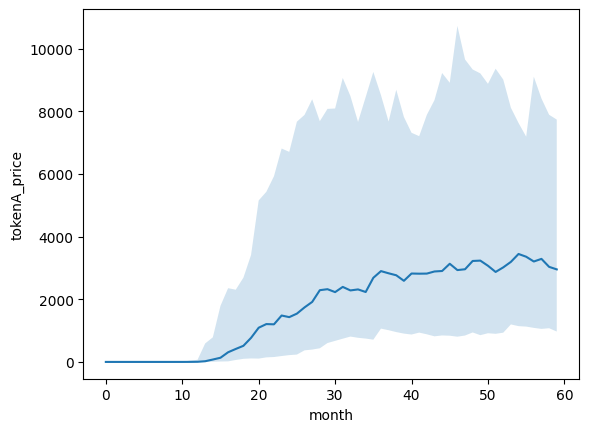

(<matplotlib.collections.PolyCollection at 0x7f9d8171dd60>,
                 tokenA_price_mean  tokenA_price_median            sd  \
 iteration_time                                                         
 0                        0.009000             0.009000  3.999706e-08   
 1                        0.008101             0.008100  4.539083e-06   
 2                        0.007293             0.007290  6.581710e-06   
 3                        0.006595             0.006564  1.628573e-04   
 4                        0.006078             0.005917  6.380224e-04   
 5                        0.005885             0.005365  1.633722e-03   
 6                        0.009665             0.005274  2.312013e-02   
 7                        0.046296             0.007287  1.779193e-01   
 8                        0.121859             0.014438  2.808882e-01   
 9                        0.315932             0.047596  7.328513e-01   
 10                       3.069582             0.223960  1.16202

In [12]:


ap_fiat=AgentPool_Basic(users_controller=users,transactions_controller=transactions,currency='$')


te=TokenEconomy_Basic(holding_time=holding_time,supply=SUPPLY,token='tokenA',
                      initial_price=INITIAL_PRICE,burn_token=True,
                      price_function_parameters={'smoothing_param':0.1})
te.add_agent_pools([ap_fiat])

meta=TokenMetaSimulator(te)
meta.execute(iterations=ITERATIONS,repetitions=100)
reps=meta.get_data()

meta.get_timeseries('tokenA_price',use_std=False)